In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks

learning_rate = 1e-4
training_iterations = 2500

dropout = 0.5
batch_size = 50
validation_size = 2000

Image_to_display = 10


Dataload

In [11]:
data = pd.read_csv('d:/resubmission/data/fashion-mnist_train.csv')

print('data{0[0]},{0[1]}'.format(data.shape))
print (data.head())

data60000,785
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0     

Data preprocessing

In [12]:
# The fit function cuts the input training data and validation data according to the specified batch size so that the model can be input batch by batch during the training process.
images = data.iloc[:,1:].values
images = images.astype(float)

images = np.multiply(images, 1.0 / 255.0)

image_width = 28
image_height = 28

#print('images{0[0]},{0[1]}'.format(images.shape))

labels = data['label'].values
labels_one_hot = to_categorical(labels)
labels_count = 10

Divide training set and validation set

In [13]:
train_images, validation_images, train_labels, validation_labels = train_test_split(images, labels_one_hot, test_size=validation_size)

Reshape data

In [14]:
train_images = train_images.reshape((-1, 28, 28, 1))
validation_images = validation_images.reshape((-1, 28, 28, 1))

In [15]:
print('shape of train：({}, {})'.format(train_images.shape[0], train_images.shape[1]))
print('shape of validation：({}, {})'.format(validation_images.shape[0], validation_images.shape[1]))

shape of train：(58000, 28)
shape of validation：(2000, 28)


Visualize an image

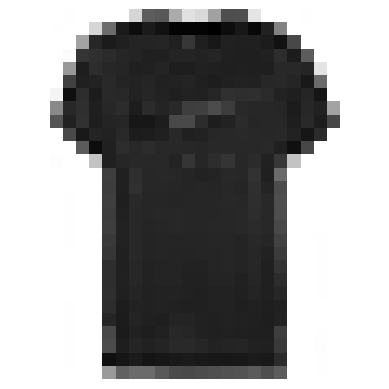

In [16]:
def display(img):
    one_size = img.reshape(image_width, image_height)

    plt.axis('off')
    plt.imshow(one_size, cmap=cm.binary)

display(images[Image_to_display])


Define a Conv2D layer

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models


class MyConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(MyConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

    def build(self, input_shape):
        input_channels = input_shape[-1]
        self.kernel = self.add_weight(name="kernel", shape=(self.kernel_size, self.kernel_size, input_channels, self.filters))
        self.bias = self.add_weight(name="bias", shape=(self.filters,))
        super(MyConv2D, self).build(input_shape)

    def call(self, inputs):
        conv_output = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME') + self.bias
        return tf.nn.relu(conv_output)


model = models.Sequential()


model.add(layers.InputLayer(input_shape=(28, 28, 1)))
model.add(MyConv2D(filters=32, kernel_size=5))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(MyConv2D(filters=64, kernel_size=5))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=labels_count, activation='softmax'))

Set learning rate 

In [19]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Set early stopping

In [21]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='d:/resubmission/model_checkpoint.keras',
    monitor='val_accuracy',
    save_best_only=True
)
tensorboard_callback = callbacks.TensorBoard(log_dir='/home/s5613008/Final_project/logs', histogram_freq=1)

In [22]:
# Before starting training, the fit function will compile the model, including setting the loss function, optimizer and indicators. These settings will be used to calculate losses, optimize model parameters, and evaluate model performance
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Train model

In [23]:
# The fit function iterates over the data in each epoch and does the following:
# Forward propagation: Perform forward propagation on the input data of each batch, and calculate the output of the model through the network.
# Calculate loss: Use the loss function to calculate the error between the model prediction and the true label.
# Backpropagation: Using the calculated loss value, the gradient of each parameter to the loss is calculated through the backpropagation algorithm.。
# Parameter update: According to the settings of the optimizer, the parameters of the model are updated to minimize the loss. The optimizer updates parameter values based on gradient descent or other optimization algorithms
# Recording metrics: At the end of each epoch, the fit function will record the metrics of the training and validation data, such as loss value and accuracy, for subsequent analysis of the model's performance.


num_epochs = 10
batch_size = 32
history = model.fit(
    train_images, train_labels, 
    epochs=num_epochs, batch_size=batch_size, 
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback],
    verbose=0 
)
print(history.history['loss']) 
print(history.history['accuracy']) 
print(history.history['val_loss'])  
print(history.history['val_accuracy']) 


# Early stopping and model saving
# At the end of each epoch, the fit function checks whether the early stopping condition is met.
#If the validation loss does not improve, early stopping takes effect and training stops early. At the same time, according to the settings of model saving, the best model parameters will be saved.

[0.6281921863555908, 0.398019015789032, 0.3476901650428772, 0.3201935291290283, 0.29737389087677, 0.28366124629974365, 0.27245697379112244, 0.26265469193458557, 0.2545756995677948, 0.2503875494003296]
[0.7726896405220032, 0.8551034331321716, 0.8727068901062012, 0.88398277759552, 0.8927068710327148, 0.8961896300315857, 0.901258647441864, 0.905327558517456, 0.9079138040542603, 0.9092068672180176]
[0.4249342978000641, 0.36344996094703674, 0.33525028824806213, 0.3081468641757965, 0.296867698431015, 0.28845852613449097, 0.2746542990207672, 0.2732800245285034, 0.2684880793094635, 0.26505082845687866]
[0.8445000052452087, 0.8679999709129333, 0.8769999742507935, 0.8899999856948853, 0.8889999985694885, 0.8949999809265137, 0.9035000205039978, 0.9010000228881836, 0.8985000252723694, 0.8995000123977661]


Model prediction results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


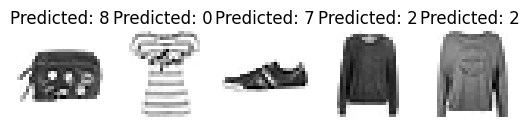

In [24]:
import numpy as np


random_indices = np.random.choice(validation_images.shape[0], size=5, replace=False)
sample_images = validation_images[random_indices]

predictions = model.predict(sample_images)

for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i+1)
    plt.imshow(sample_images[i].reshape(image_width, image_height), cmap=cm.binary)
    plt.title(f"Predicted: {np.argmax(predictions[i])}")
    plt.axis('off')
plt.show()

In [25]:
# Load test data
test_data = pd.read_csv('d:/resubmission/data/fashion-mnist_test.csv')
test_images = test_data.iloc[:,1:].values
test_images = test_images.astype(float)
test_images = np.multiply(test_images, 1.0 / 255.0)
test_labels = test_data['label'].values
test_labels_one_hot = to_categorical(test_labels)

# Reshape test data
test_images = test_images.reshape((-1, 28, 28, 1))

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot, verbose=0)

# Display test accuracy and loss percentage
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.2f}%".format(test_loss * 100))

Test Accuracy: 90.92%
Test Loss: 24.96%
